In [246]:
import sys
import pandas as pd

Challenge 1:

In [248]:
dates1 = [200530, 200523, 200516, 200509, 200502, 200425, 200418, 200411, 200404, 200328, 200321]
dates2 = [190525, 190518, 190511, 190504, 190427, 190420, 190413, 190406, 190330, 190323, 190316]
def make_df(dates):
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for date in dates:
        link = url.format(date)
        dfx = pd.read_csv(link)
        dfs.append(dfx)
    df = pd.concat(dfs, ignore_index=True)
    for column in df.columns:
        df.rename(columns={column: column.lower().strip()}, inplace=True)
    return df

df_post = make_df(dates1)
df_pre = make_df(dates2)

Challenge 2:

In [249]:
def add_datetime(df):
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%m/%d/%Y %H:%M:%S')
add_datetime(df_pre)
add_datetime(df_post)

In [250]:
df_post.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2020,00:00:00,REGULAR,7418881,2519932,2020-05-23 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2020,04:00:00,REGULAR,7418881,2519933,2020-05-23 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2020,08:00:00,REGULAR,7418886,2519940,2020-05-23 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2020,12:00:00,REGULAR,7418899,2519951,2020-05-23 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/23/2020,16:00:00,REGULAR,7418933,2519964,2020-05-23 16:00:00


In [251]:
df_pre.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,00:00:00,REGULAR,7062481,2393489,2019-05-18 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,04:00:00,REGULAR,7062505,2393492,2019-05-18 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,08:00:00,REGULAR,7062529,2393526,2019-05-18 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,12:00:00,REGULAR,7062627,2393612,2019-05-18 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,7062835,2393662,2019-05-18 16:00:00


Challenge 3 and simplifying the data to make it more manageable and portable as csv

In [252]:
def clean_df(df):
    df.drop(columns=['c/a','exits','desc','division'], inplace=True)
    df.sort_values(['unit', 'scp','station','datetime'], inplace=True, ascending=False)
    df.drop_duplicates(subset=['scp','station','datetime'], inplace=True)
clean_df(df_pre)
clean_df(df_post)

In [253]:
def make_daily_counts(df):
    df_daily_counts = df.groupby(['unit', 'scp','station','date']).entries.first().reset_index()
    return df_daily_counts
pre_dailies = make_daily_counts(df_pre)
post_dailies = make_daily_counts(df_post)

In [254]:
post_dailies.head()

,unit,scp,station,date,entries
0,R001,00-00-00,WHITEHALL S-FRY,03/14/2020,5031852
1,R001,00-00-00,WHITEHALL S-FRY,03/15/2020,5032650
2,R001,00-00-00,WHITEHALL S-FRY,03/16/2020,5033943
3,R001,00-00-00,WHITEHALL S-FRY,03/17/2020,5035110
4,R001,00-00-00,WHITEHALL S-FRY,03/18/2020,5036176


In [255]:
pre_dailies.head()

,unit,scp,station,date,entries
0,R001,00-00-00,WHITEHALL S-FRY,03/09/2019,4136720
1,R001,00-00-00,WHITEHALL S-FRY,03/10/2019,4137836
2,R001,00-00-00,WHITEHALL S-FRY,03/11/2019,4140665
3,R001,00-00-00,WHITEHALL S-FRY,03/12/2019,4143382
4,R001,00-00-00,WHITEHALL S-FRY,03/13/2019,4146205


In [256]:
def add_prev(df):
    df[['prev_date', 'prev_entries']] = df.groupby(['scp','station'])[['date','entries']].apply(lambda line: line.shift(1))

add_prev(pre_dailies)
add_prev(post_dailies)

In [257]:
def rmna(df):
    df.dropna(subset=['prev_date'], axis=0, inplace=True)
rmna(pre_dailies)
rmna(post_dailies)

In [73]:
import numpy as np

In [258]:
def get_dailies(row):
    delta = row.entries - row.prev_entries
    if delta < 0:
        delta = -delta
    if delta > 100000:
        delta = min(row.entries, row.prev_entries)
    if delta > 100000:
        return np.nan
    return delta

pre_dailies['day_count'] = pre_dailies.apply(get_dailies, axis=1)
post_dailies['day_count'] = post_dailies.apply(get_dailies, axis=1)

In [263]:
post_dailies.sample()

,unit,scp,station,date,entries,prev_date,prev_entries,day_count
242583,R293,00-03-00,34 ST-PENN STA,2020-05-09,97878784,05/08/2020,97878815.0,31.0


In [262]:
pre_dailies.head()

,unit,scp,station,date,entries,prev_date,prev_entries,day_count
1,R001,00-00-00,WHITEHALL S-FRY,2019-03-10,4137836,03/09/2019,4136720.0,1116.0
2,R001,00-00-00,WHITEHALL S-FRY,2019-03-11,4140665,03/10/2019,4137836.0,2829.0
3,R001,00-00-00,WHITEHALL S-FRY,2019-03-12,4143382,03/11/2019,4140665.0,2717.0
4,R001,00-00-00,WHITEHALL S-FRY,2019-03-13,4146205,03/12/2019,4143382.0,2823.0
5,R001,00-00-00,WHITEHALL S-FRY,2019-03-14,4149075,03/13/2019,4146205.0,2870.0


In [261]:
def to_datetime(df):
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
to_datetime(pre_dailies)
to_datetime(post_dailies)

In [265]:
pre_dailies.to_csv('2019_mta_counts.csv')
post_dailies.to_csv('2020_mta_counts.csv')

Restart here if you don't want to reload everything from above

In [109]:
pre_dailies = pd.read_csv('2019_mta_counts.csv')
post_dailies = pd.read_csv('2020_mta_counts.csv')

Challenge 4:

In [266]:
%matplotlib inline
import matplotlib.pyplot as plt

In [267]:
mask = ((pre_dailies.scp == '00-00-02') &
        (pre_dailies.station == 'CLARK ST'))
pre_counts = pre_dailies[mask].day_count
pre_dates = pre_dates = pre_dailies[mask].date

In [298]:
mask = ((post_dailies.scp == '00-00-02') &
        (post_dailies.station == 'CLARK ST'))
post_counts = post_dailies[mask].day_count
post_dates = post_dailies[mask].date

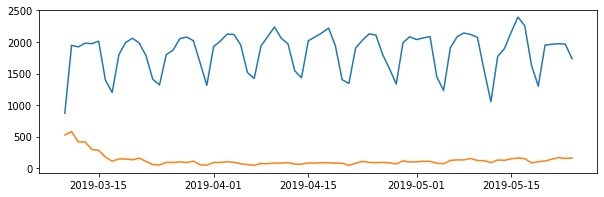

In [270]:
plt.figure(figsize=(10,3))
plt.plot(pre_dates,pre_counts)
plt.plot(pre_dates,post_counts)

Challenge 5

In [271]:
pre_stations = pre_dailies.groupby(['station', 'date'])['day_count'].sum().reset_index()
pre_stations.tail()

,station,date,day_count
28705,ZEREGA AV,2019-05-20,2745.0
28706,ZEREGA AV,2019-05-21,2856.0
28707,ZEREGA AV,2019-05-22,2872.0
28708,ZEREGA AV,2019-05-23,2768.0
28709,ZEREGA AV,2019-05-24,2737.0


In [272]:
post_stations = post_dailies.groupby(['station', 'date'])['day_count'].sum().reset_index()

Challenge 6

In [273]:
from collections import defaultdict

In [309]:
pre_time_series = defaultdict(list)
for row in pre_stations.itertuples():
    pre_time_series[row[1]].append((np.datetime64(row[2]), row[3]))

In [310]:
post_time_series = defaultdict(list)
for row in post_stations.itertuples():
    post_time_series[row[1]].append((np.datetime64(row[2]), row[3]))

Challenge 7:

In [289]:
import numpy as np

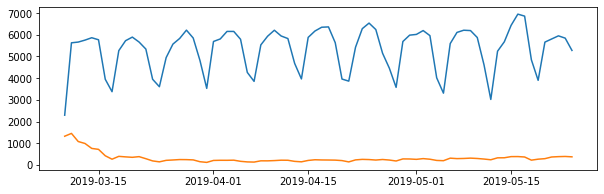

In [311]:
unzipped = list(zip(*pre_time_series['CLARK ST']))
dates = unzipped[0]
counts = unzipped[1]
plt.figure(figsize=(10,3))
plt.plot(dates, counts)
post_unzip = list(zip(*post_time_series['CLARK ST']))
post_dates = post_unzip[0]
post_counts = post_unzip[1]
plt.plot(pre_dates, post_counts)

Challenge 8:

In [301]:
pd.Timestamp(dates[0])

Timestamp('2019-03-10 00:00:00')

In [305]:
pre_days_series = defaultdict(list)
for row in pre_stations.itertuples():
    pre_days_series[row[1]].append((row[2], row[2].strftime('%A'), row[3]))

In [315]:
post_days_series = defaultdict(list)
for row in post_stations.itertuples():
    post_days_series[row[1]].append((row[2], row[2].strftime('%A'), row[3]))

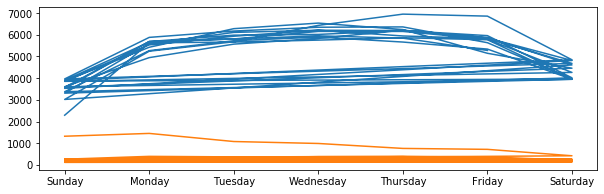

In [321]:
unzipped = list(zip(*pre_days_series['CLARK ST']))
day = unzipped[1]
counts = unzipped[2]
plt.figure(figsize=(10,3))
plt.plot(day, counts)
post_unzip = list(zip(*post_days_series['CLARK ST']))
post_day = post_unzip[1]
post_counts = post_unzip[2]
plt.plot(post_day, post_counts)

Challenge 9:

In [331]:
total_pre = pre_stations.groupby('station')['day_count'].sum().reset_index().sort_values('day_count', ascending=False).head(10)

In [332]:
total_post = post_stations.groupby('station')['day_count'].sum().reset_index().sort_values('day_count', ascending=False).head(10)

Challenge 10:

(array([3., 1., 0., 0., 0., 1., 0., 1., 1., 3.]),
 array([485920. , 506557.4, 527194.8, 547832.2, 568469.6, 589107. ,
        609744.4, 630381.8, 651019.2, 671656.6, 692294. ]),
 <a list of 10 Patch objects>)

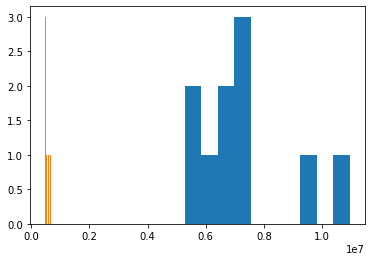

In [334]:
plt.hist(total_pre.day_count)
plt.hist(total_post.day_count)